In [ ]:
# Mount on Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install --upgrade texttable git+https://github.com/lorenzobasile/DeepRobust.git
!pip install advertorch

  Cloning https://github.com/lorenzobasile/DeepRobust.git to /tmp/pip-req-build-ko2_mic0
  Running command git clone -q https://github.com/lorenzobasile/DeepRobust.git /tmp/pip-req-build-ko2_mic0
     |████████████████████████████████| 204kB 3.9MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for deeprobust: filename=deeprobust-0-cp36-none-any.whl size=142494 sha256=126a2f33d59e2c1069203d6809d587aafe40153f3cf6b851c582aafd7a10e6a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ugx491c/wheels/73/c5/ae/8043f3f08a70c4c2a4584449a4f97f415682a4f0371f8f3890
Successfully built deeprobust
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


     |████████████████████████████████| 5.7MB 2.5MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=b8efb1cbf242b98135a900206ee6c37ea4c3fbdc1bde49180eb1cd7c49b9f7b7
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [ ]:
# Going to my directory

%cd gdrive/My\ Drive/Colab Notebooks/project_rob

/content/gdrive/My Drive/Colab Notebooks/project_rob


In [ ]:
%ls

 Advertorch_mnist_imagenet.ipynb      data/                 plots/
 Belgium_signs_FGSM.ipynb             defense_models/       TherEnc_64_20e.h5
 classes/                             fgsm_64_20e_eps0.h5   Untitled0.ipynb
'Copia di Belgium_signs_FGSM.ipynb'   models/


In [ ]:
## LIBRARIES

## Usual python tools
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display

## Torch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Torchvision
import torchvision 

## DeepRobust
import deeprobust.image.netmodels.train_model as trainmodel
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.defense.fast import Fast
from deeprobust.image.defense.YOPO import YOPOpgd
from deeprobust.image.attack.onepixel import Onepixel
from deeprobust.image.config import attack_params
import deeprobust.image.netmodels.CNN as MODEL
from torchvision import transforms, datasets
from deeprobust.image.defense.fgsmtraining import FGSMtraining 
from deeprobust.image.defense.pgdtraining import PGDtraining
from deeprobust.image.config import defense_params
from deeprobust.image.netmodels.CNN import Net

## Advertorch
from advertorch.attacks import SinglePixelAttack

## Pandas 
import pandas as pd

In [ ]:
## LOAD CLASSES AND BUILD DICTIONARY

signs = pd.read_table("classes/classes.txt", header=None, names=['Belgium signs'])

dicts = {}
for i in range(0,62):
  dicts[i] = signs['Belgium signs'][i]

print(dicts)

{0: 'uneven road', 1: 'humps', 2: 'slippery road', 3: 'bend, to left', 4: 'bend, to right', 5: 'double bend, first to left', 6: 'double bend, first to right', 7: 'children', 8: 'bicycle crossing', 9: 'cattle', 10: 'road works', 11: 'traffic lights', 12: 'level crossing with barrier', 13: 'other danger', 14: 'road narrows', 15: 'road narrows on left', 16: 'road narrows on right', 17: 'crossroads', 18: 'crossroads with right-of-way from the right', 19: 'give way', 20: 'priority from opposite direction', 21: 'stop', 22: 'no entry', 23: 'no bicycles', 24: 'max weight', 25: 'no heavy load', 26: 'max width', 27: 'max height', 28: 'traffic not allowed', 29: 'no turn left', 30: 'no turn right', 31: 'no overtaking', 32: 'max speed', 33: 'pedestrian zone', 34: 'drive straight', 35: 'turn', 36: 'drive straight or turn right', 37: 'roundabout', 38: 'bicycles only', 39: 'bicycles and pedestrians', 40: 'no parking', 41: 'no stopping on the side ', 42: 'no parking', 43: 'no parking 16-31', 44: 'prior

In [ ]:
torch.manual_seed(torch.rand(1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [ ]:
## SOME USEFUL FUNCTIONS

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, vmin=0, vmax=1)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

In [ ]:
## TRANSFORMATIONS

data_transforms = {'Training': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ]),
                   'Testing': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ])
                   }

In [ ]:
## LOADING DATA

# Location of data
data_dir = './data/'

# Load dataset
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
# Create dataloaders (test and train)
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=64, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=64, shuffle=True)}

# Save sizes and classes
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}
class_names = datasets['Training'].classes

In [ ]:
## PRINT SOME INFO ABOUT DATA

print(dataloaders['Training'].dataset)
print()
print(dataloaders['Testing'].dataset)

Dataset ImageFolder
    Number of datapoints: 4613
    Root location: ./data/Training
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )

Dataset ImageFolder
    Number of datapoints: 2520
    Root location: ./data/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )


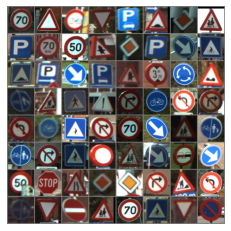

In [ ]:
## PRINT SOME IMAGES

# Train
inputs, classes = next(iter(dataloaders['Training']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Test
inputs, classes = next(iter(dataloaders['Testing']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
## LOAD GOOGLENET

net=torchvision.models.googlenet(pretrained=True, progress=True)
net.fc=nn.Linear(net.fc.in_features,62)
net.to(device)
net.load_state_dict(torch.load("models/64_20e.h5"), strict=False)

<All keys matched successfully>

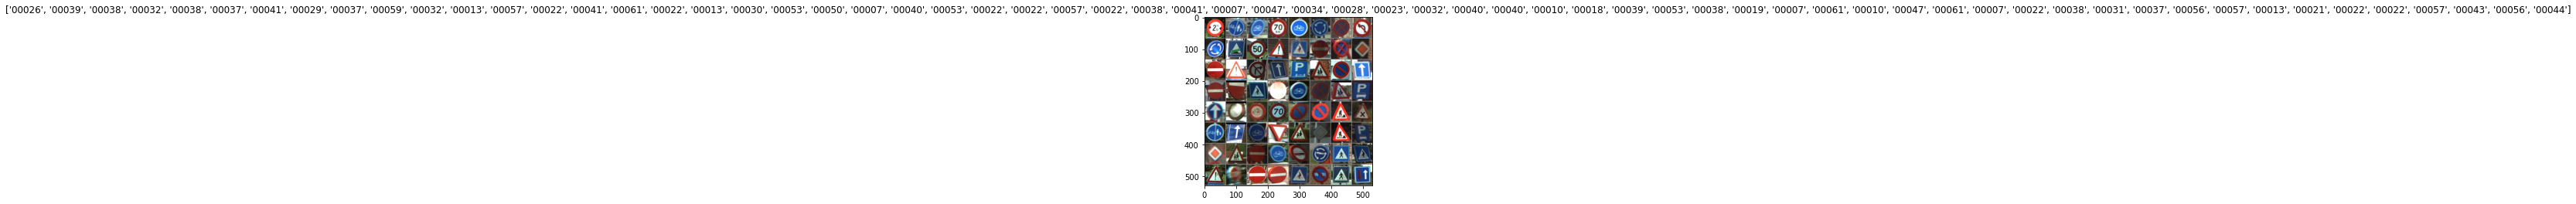

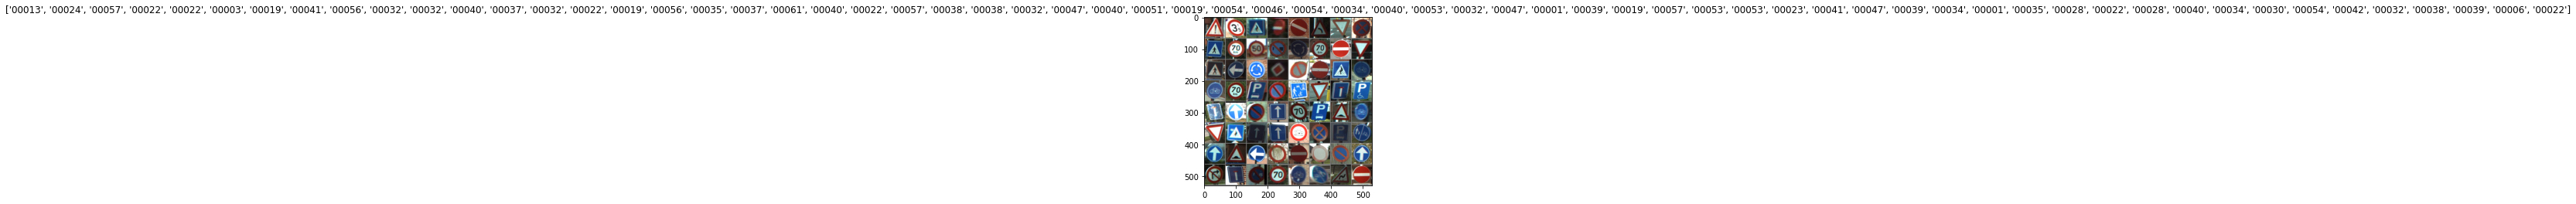

KeyboardInterrupt: ignored

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
i=0
while i<10:
    i+=1
    inputs, classes = next(iter(dataloaders['Training']))


    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders['Testing']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [ ]:
# TRAINING GOOGLENET
net.to(device)
lr = 0.001
epochs = 20

n_batches = len(dataloaders['Training'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

net.train() 
for e in range(epochs):
    for i, data in enumerate(dataloaders['Training']):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)
    scheduler.step()
torch.save(net.state_dict(), "./64_20e.h5")

[EPOCH]: 19, [BATCH]: 50/72, [LOSS]: 0.0003434866666793823


In [ ]:
#CLEAN ACCURACIES ON TRAIN AND TEST
#acc_train = get_accuracy(dataloaders['Training'], net, device=device)
#print("Train accuracy: {}".format(acc_train))
net.eval()
acc_test = get_accuracy(dataloaders['Testing'], net, device=device)
print("\nTest accuracy: {}".format(acc_test))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
def _show_images(img, advimg, pred, advpred, clean_prob, adv_prob, epsilon):
    
  perturb = advimg - img
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.3, 0.3, 0.3])
  figure, ax = plt.subplots(1,3, figsize=(12,8))
  
  img = img.numpy().transpose((1, 2, 0))
  img = std * img + mean
  img = np.clip(img, 0, 1)
  ax[0].imshow(img)
  ax[0].axis("off")
  ax[0].set_title("original image\n prediction: {}".format(dicts[pred]),fontsize=15)
  ax[0].text(0.5,-0.13, s = "probability {:.2f} %".format(clean_prob),size=14, ha="center", 
       transform=ax[0].transAxes)
  
  perturb = perturb.numpy().transpose((1, 2, 0))
  perturb = std * perturb + mean
  perturb = np.clip(perturb, 0, 1)
  ax[1].imshow(perturb)
  ax[1].axis("off")
  ax[1].set_title("the perturbation \n epsilon: {:.2f}".format(epsilon), fontsize=15)
  
  advimg = advimg.numpy().transpose((1, 2, 0))
  advimg = std * advimg + mean
  advimg = np.clip(advimg, 0, 1)
  ax[2].imshow(advimg)
  ax[2].axis("off")
  ax[2].set_title("perturbed image\n prediction: {}".format(dicts[advpred]), fontsize=15)
  ax[2].text(0.5,-0.13, s = "probability {:.2f} %".format(adv_prob), size=14, ha="center", 
       transform=ax[2].transAxes)
  plt.show()

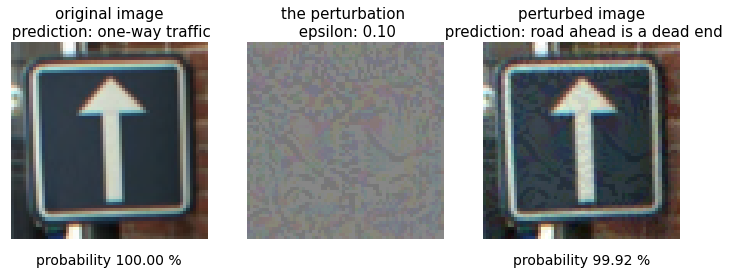

In [ ]:
## PGD Attack

x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()

adversary = PGD(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.1)

output_adv_before = net(Adv_img)
output_img_before = net(x)

img_soft = F.softmax(output_img_before, dim=1)
img_prob =((torch.max(img_soft.data, 1)[0][0]) * 100)

adv_soft = F.softmax(ooutput_adv_before, dim=1)
adv_prob =((torch.max(adv_soft.data, 1)[0][0]) * 100)

_show_images(img=x[0].cpu().detach(), advimg=Adv_img[0].cpu().detach(), 
             pred=torch.argmax(output_img_before , dim=1)[0].item(), advpred=torch.argmax(output_adv_before, dim=1)[0].item(), 
             clean_prob=img_prob, adv_prob=adv_prob, epsilon=0.1)

In [ ]:
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]

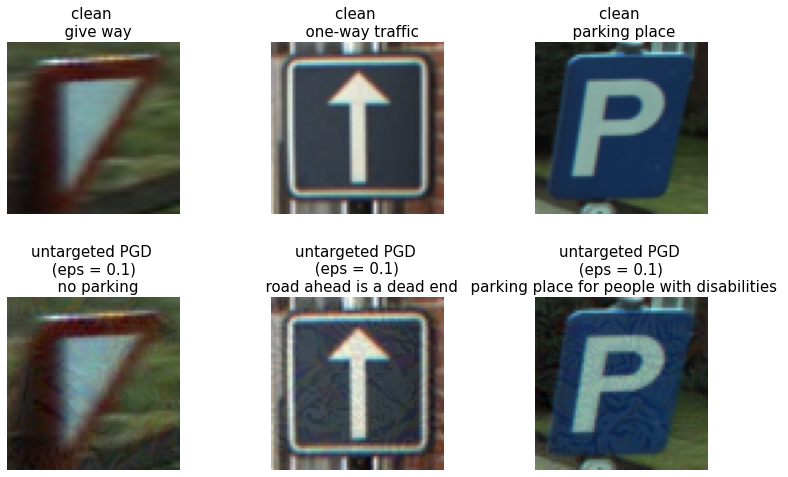

In [ ]:
x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()


adversary = PGD(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.1)

output_adv = net(Adv_img)
output_img = net(x)

pred=torch.argmax(output_img, dim=1)
advpred=torch.argmax(output_adv, dim=1)

plt.figure(figsize=(11,7))
batch_size = 3

for ii in range(3):
    plt.subplot(2, batch_size, ii + 1)
    imshow(x[ii].cpu().detach())
    plt.title("clean \n  {}".format(dicts[pred[ii].item()]), fontsize=15)
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    imshow(Adv_img[ii].cpu().detach())
    plt.title("untargeted PGD \n (eps = {}) \n  {}".format(0.1, dicts[advpred[ii].item()]), fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
### ADVERSARIAL ACCURACY OF GOOGLENET 

adversarial_accuracies_before = []

# Evaluate model on adversarial attacks
for eps in epsilons:
  correct = 0
  batch_number = 0
  tot = len(dataloaders['Testing'].dataset)
  
  for data, target in dataloaders['Testing']:
  
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]

    # Call PGD Attack
    adversary = PGD(net, 'cuda')
    Adv_img = adversary.generate(data, target, epsilon = eps)

    # Re-classify the perturbed image
    output = net(Adv_img)

    # Check for success
    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

    correct += torch.sum(target == final_pred)

  adversarial_accuracies_before.append(float(correct)/float(tot))
  print("Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(eps, correct, tot, float(correct)/float(tot)*100))

Epsilon = 0.3: adversarial test Accuracy = 1 / 2520 -> 0.04%
Epsilon = 0.2: adversarial test Accuracy = 5 / 2520 -> 0.20%
Epsilon = 0.15: adversarial test Accuracy = 13 / 2520 -> 0.52%
Epsilon = 0.1: adversarial test Accuracy = 100 / 2520 -> 3.97%
Epsilon = 0.05: adversarial test Accuracy = 897 / 2520 -> 35.60%
Epsilon = 0.03: adversarial test Accuracy = 1748 / 2520 -> 69.37%
Epsilon = 0.01: adversarial test Accuracy = 2371 / 2520 -> 94.09%


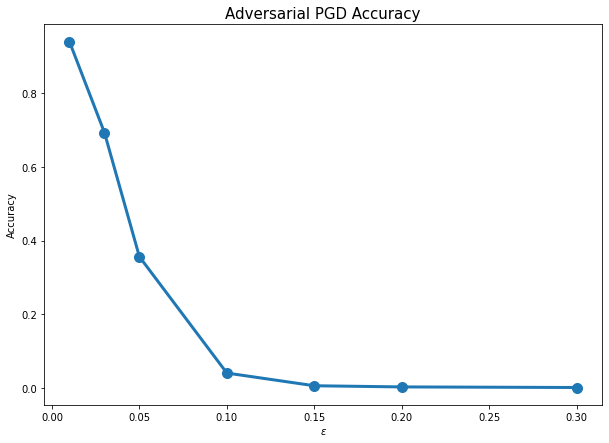

In [ ]:
plt.figure(figsize=(10, 7))
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]

plt.plot(epsilons, adversarial_accuracies_before, lw=3, linestyle='-', marker='o', markersize=10)
plt.title("Adversarial PGD Accuracy", fontsize=15)
plt.xlabel("$\epsilon$", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.savefig("plots/pgd_attack_good.png")

In [ ]:
#PGD TRAINING
#epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]
epsilons = [0.3, 0.2, 0.15, 0.1]
for eps in epsilons:
    net.to(device)
    net.load_state_dict(torch.load("./64_20e.h5"), strict=False)
    defense = PGDtraining(net, device)
    defense.generate(train_loader=dataloaders['Training'], test_loader=dataloaders['Testing'], epsilon=eps, epoch= 5,
                    lr = 0.001, save_model = False)
    torch.save(net.state_dict(), "./pgd_64_5e_eps%f.h5"%eps)

1
Train Epoch: 1 [0/4575 (0%)]	Loss: 4.416819	Accuracy:0.00%
Train Epoch: 1 [640/4575 (14%)]	Loss: 0.548792	Accuracy:23.28%
Train Epoch: 1 [1280/4575 (28%)]	Loss: 0.137540	Accuracy:32.97%
Train Epoch: 1 [1920/4575 (42%)]	Loss: -0.972185	Accuracy:43.28%
Train Epoch: 1 [2560/4575 (56%)]	Loss: -1.934402	Accuracy:48.91%
Train Epoch: 1 [3200/4575 (69%)]	Loss: -2.402004	Accuracy:51.72%
Train Epoch: 1 [3840/4575 (83%)]	Loss: -2.529953	Accuracy:53.59%
Train Epoch: 1 [4480/4575 (97%)]	Loss: -3.553614	Accuracy:60.16%

Test set: Clean loss: -6.752, Clean Accuracy: 2347/2520 (93%)


Test set: Adv loss: -2.329, Adv Accuracy: 1015/2520 (40%)

2
Train Epoch: 2 [0/4575 (0%)]	Loss: -3.800711	Accuracy:6.88%
Train Epoch: 2 [640/4575 (14%)]	Loss: -4.110688	Accuracy:60.47%
Train Epoch: 2 [1280/4575 (28%)]	Loss: -4.717599	Accuracy:63.28%
Train Epoch: 2 [1920/4575 (42%)]	Loss: -5.359456	Accuracy:63.59%
Train Epoch: 2 [2560/4575 (56%)]	Loss: -5.845324	Accuracy:65.78%
Train Epoch: 2 [3200/4575 (69%)]	Loss: -6.

In [ ]:
%ls models/

'64_20e(1).h5'                pgd_64_5e_eps0.010000.h5
 64_20e.h5                    pgd_64_5e_eps0.030000.h5
 fgsm_64_20e_eps0.010000.h5  'pgd_64_5e_eps0.050000(1).h5'
 fgsm_64_20e_eps0.030000.h5   pgd_64_5e_eps0.050000.h5
 fgsm_64_20e_eps0.050000.h5   pgd_64_5e_eps0.100000.h5
 fgsm_64_20e_eps0.100000.h5   pgd_64_5e_eps0.150000.h5
 fgsm_64_20e_eps0.150000.h5   pgd_64_5e_eps0.200000.h5
 fgsm_64_20e_eps0.200000.h5   pgd_64_5e_eps0.300000.h5
 fgsm_64_20e_eps0.300000.h5   TherEnc_64_20e.h5
 fgsm_64_20e_eps0.h5


In [ ]:
### ADVERSARIAL ACCURACY OF GOOGLENET AFTER ADVERSARIAL TRAINING


adversarial_accuracies_after = []

# Evaluate model on adversarial attacks
for eps in epsilons:
  net.load_state_dict(torch.load('models/pgd_64_5e_eps%f.h5'%eps), strict=False) 

  correct = 0
  batch_number = 0
  tot = len(dataloaders['Testing'].dataset)
  
  for data, target in dataloaders['Testing']:
  
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]

    ## Call PGD Attack
    adversary = PGD(net, 'cuda')
    Adv_img = adversary.generate(data, target, epsilon = eps)

    # Re-classify the perturbed image
    output = net(Adv_img)

    # Check for success
    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

    correct += torch.sum(target == final_pred)

  adversarial_accuracies_after.append(float(correct)/float(tot))
  print("Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(eps, correct, tot, float(correct)/float(tot)*100))

Epsilon = 0.3: adversarial test Accuracy = 1317 / 2520 -> 52.26%
Epsilon = 0.2: adversarial test Accuracy = 1462 / 2520 -> 58.02%
Epsilon = 0.15: adversarial test Accuracy = 1789 / 2520 -> 70.99%
Epsilon = 0.1: adversarial test Accuracy = 2087 / 2520 -> 82.82%
Epsilon = 0.05: adversarial test Accuracy = 2264 / 2520 -> 89.84%
Epsilon = 0.03: adversarial test Accuracy = 2186 / 2520 -> 86.75%
Epsilon = 0.01: adversarial test Accuracy = 2344 / 2520 -> 93.02%


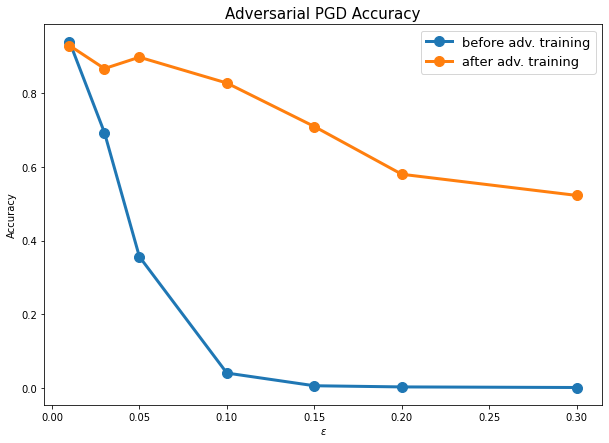

In [ ]:
## PLOT ACCURACIES BEFORE/AFTER ADVERSARIAL TRAINING

plt.figure(figsize=(10, 7))
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]

plt.plot(epsilons, adversarial_accuracies_before, lw=3, label='before adv. training', linestyle='-', marker='o', markersize=10)
plt.plot(epsilons, adversarial_accuracies_after, lw=3, label='after adv. training', linestyle='-', marker='o', markersize=10)
plt.title("Adversarial PGD Accuracy", fontsize=15)
plt.xlabel("$\epsilon$", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend(fontsize=13)
plt.savefig("plots/pgd_attack_good.png")

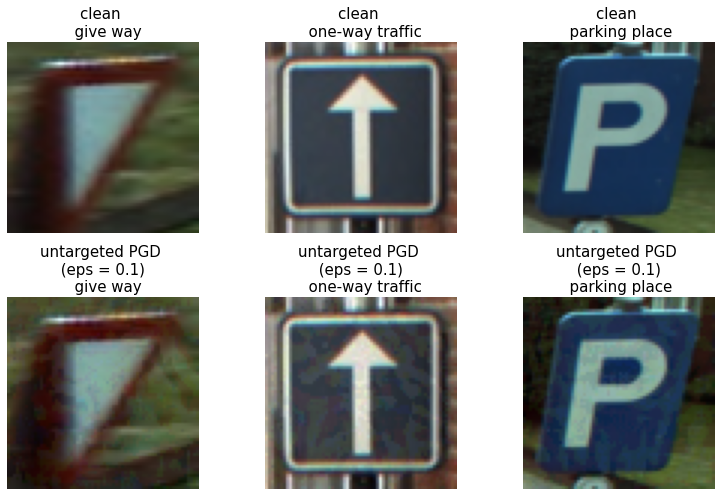

In [ ]:
## SHOW IMAGES AND PREDICTION OF THE NET ON ADV. ATTACKS (EPSILON=0.1)
## THE NET NOW HAS DONE ADV.TRAINING

net.load_state_dict(torch.load('models/pgd_64_5e_eps%f.h5'%epsilons[3]), strict=False)

adversary = PGD(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = epsilons[3])

output_adv = net(Adv_img)
output_img = net(x)

pred=torch.argmax(output_img, dim=1)
advpred=torch.argmax(output_adv, dim=1)

plt.figure(figsize=(11,7))
batch_size = 3

for ii in range(3):
    plt.subplot(2, batch_size, ii + 1)
    imshow(x[ii].cpu().detach())
    plt.title("clean \n  {}".format(dicts[pred[ii].item()]), fontsize=15)
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    imshow(Adv_img[ii].cpu().detach())
    plt.title("untargeted PGD \n (eps = {}) \n  {}".format(0.1, dicts[advpred[ii].item()]), fontsize=15)

plt.tight_layout()
plt.show()